Import all libraries that used for this panorama stitching

In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install scipy
!pip install ipywidgets

In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import random
from tqdm.notebook import tqdm

In [34]:
#load image 
def load_images(dataset):
    data1=['data1/1.JPG','data1/2.JPG','data1/3.JPG','data1/4.JPG','data1/5.JPG','data1/6.JPG']
    data2 =['data2/IMG_0488.JPG','data2/IMG_0489.JPG','data2/IMG_0490.JPG','data2/IMG_0491.JPG']
    data3 =['data3/IMG_0675.JPG','data3/IMG_0676.JPG','data3/IMG_0677.JPG']
    data4 = ['data4/IMG_7355.JPG','data4/IMG_7356.JPG','data4/IMG_7357.JPG','data4/IMG_7358.JPG']
    if dataset =='data1':
        image_paths = data1
    elif dataset == 'data2':
        image_paths = data2
    elif dataset == 'data3':
        image_paths = data3
    else:
        image_paths = data4
    return [cv2.imread(path) for path in image_paths]

# Feature detection, description and matching part : SIFT descriptor or the concatenated pixel values within a local window

SIFT

In [4]:

def SIFT (image):
    #image input is RGB, so this function, we want to detect sift keypoint and compute descriptor
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # RGB into gray 
    sift = cv2.SIFT_create()
    keypoint,descriptors = sift.detectAndCompute(gray,None)
    return keypoint,descriptors
def visualization_sift(image,keypoints):
    image_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(0, 255, 0)) # Draw the keypoints in image
    image_keypoints = cv2.cvtColor(image_keypoints, cv2.COLOR_BGR2RGB) # convert image from gray into rgb
    plt.figure(figsize=(10, 6))
    plt.imshow(image_keypoints)
    plt.axis('off')

    plt.show()



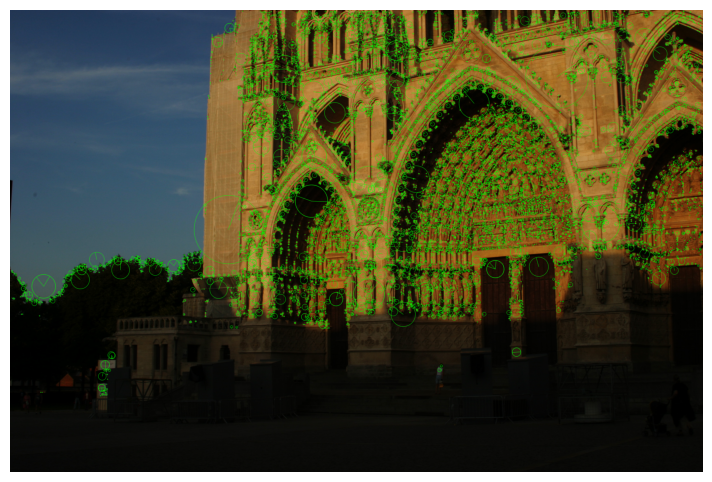

In [7]:
#try to visual image as an example 
image = cv2.imread('data1/1.JPG')
keypoints,descriptors = SIFT(image)
visualization_sift(image,keypoints)

Concatenated pixel values within a local window by using Harris corner detection

In [8]:
def local_window_descriptors(image,window_size=9):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # RGB into gray 
    keypoints,_ = SIFT(image)
    half_size = window_size // 2
    descriptors = []
    valid_keypoints = []
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        if (x - half_size >= 0 and x + half_size < gray.shape[1] and y - half_size >= 0 and y + half_size < gray.shape[0]):
            window = gray[y - half_size:y + half_size + 1, x - half_size:x + half_size + 1]
            descriptor = window.flatten()
            descriptors.append(descriptor)
            valid_keypoints.append(kp)
    return valid_keypoints, np.array(descriptors)


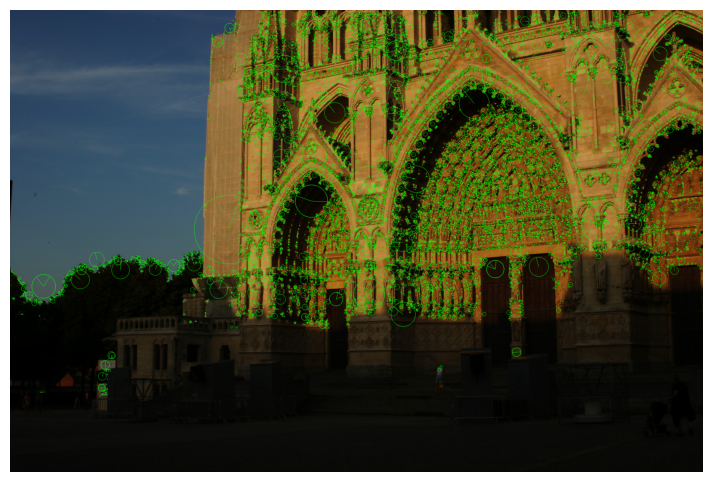

In [9]:
#try to visual image as an example 
image1 = cv2.imread('data1/1.JPG')
valid_keypoints, descriptors = local_window_descriptors(image1)
visualization_sift(image1,valid_keypoints)

Matching part

In [10]:
def matching_feature(descriptors1, descriptors2, ratio=0.75):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append([m.queryIdx, m.trainIdx])  
    return good_matches

def draw_matches(img1, kp1, img2, kp2, matches):
    dmatches = [cv2.DMatch(_queryIdx=idx1, _trainIdx=idx2, _distance=0) for idx1, idx2 in matches]
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, dmatches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return match_img

Matching USING SIFT

In [13]:
#Using SIFT
image1 = cv2.imread('data1/1.JPG')
keypoints1,descriptors1 = SIFT(image1)
image2 = cv2.imread('data1/2.JPG')
keypoints2,descriptors2 = SIFT(image2)
matching = matching_feature(descriptors1,descriptors2)
matching_image = draw_matches(image1,keypoints1, image2,keypoints2, matching)

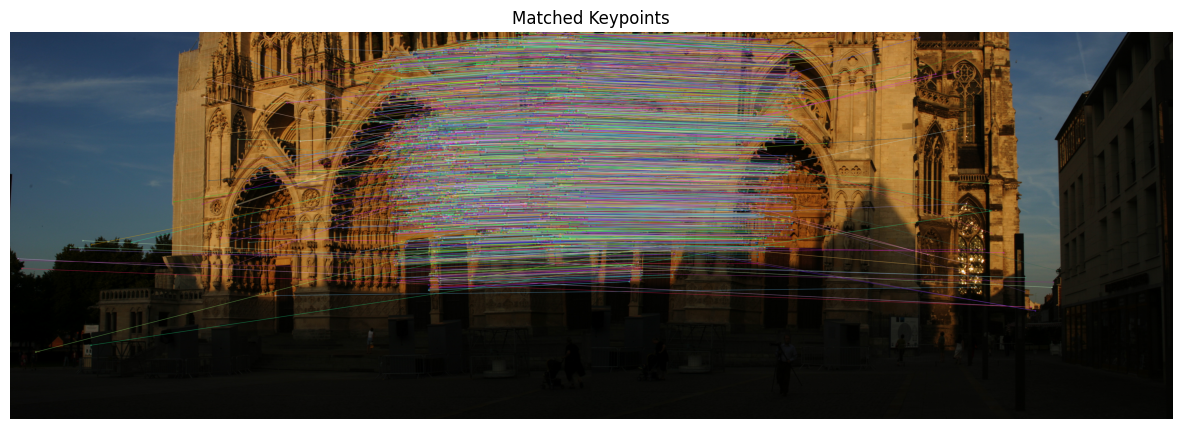

In [10]:
cv2.imwrite('output/sift_matches.jpg', matching_image)
plt.figure(figsize=(15, 6))
plt.imshow(cv2.cvtColor(matching_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.axis('off')  # Hide axes
plt.title('Matched Keypoints')
plt.show()

Matching using local window by using Harris corner detection

In [15]:
#Using local window by using Harris corner detection
image1 = cv2.imread('data1/1.JPG')
valid_keypoints1, descriptors1 = local_window_descriptors(image1)
image2 = cv2.imread('data1/2.JPG')
valid_keypoints2, descriptors2 = local_window_descriptors(image2)
matching = matching_feature(descriptors1,descriptors2)
matching_image = draw_matches(image1,valid_keypoints1, image2,valid_keypoints2, matching)

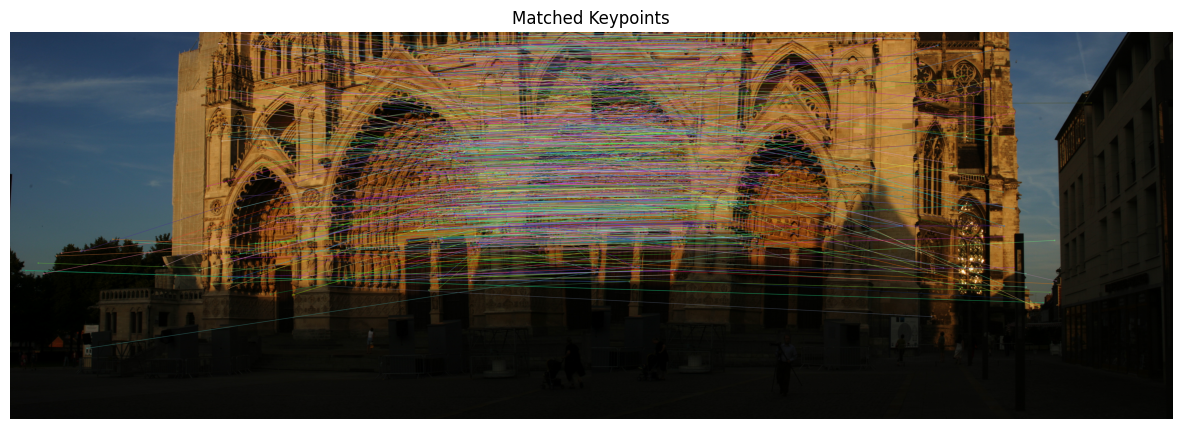

In [16]:
cv2.imwrite('output/local_window_matches.jpg', matching_image)
plt.figure(figsize=(15, 6))
plt.imshow(cv2.cvtColor(matching_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.axis('off')  # Hide axes
plt.title('Matched Keypoints')
plt.show()

# Estimation of homography

In [17]:
def homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):
        p1 = np.append(pairs[i][0:2], 1)  
        p2 = np.append(pairs[i][2:4], 1)  
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        rows.append(row1)
        rows.append(row2)
    
    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)
    H = V[-1].reshape(3, 3)
    H = H / H[2, 2] 
    return H

def random_point(matches, keypoints1, keypoints2, k=4):
    idx = random.sample(range(len(matches)), k)
    point = []
    for i in idx:
        p1 = [keypoints1[matches[i][0]].pt[0], keypoints1[matches[i][0]].pt[1]]  
        p2 = [keypoints2[matches[i][1]].pt[0], keypoints2[matches[i][1]].pt[1]]  
        point.append([*p1, *p2]) 
    return np.array(point)

def get_error(matches, H, keypoints1, keypoints2):
    num_points = len(matches)
    all_p1 = np.concatenate((np.array([keypoints1[m[0]].pt for m in matches]), np.ones((num_points, 1))), axis=1)  
    all_p2 = np.array([keypoints2[m[1]].pt for m in matches])
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i]) 
        estimate_p2[i] = (temp / temp[2])[0:2] 
    errors = np.linalg.norm(all_p2 - estimate_p2, axis=1) ** 2
    return errors

def ransac(matches, keypoints1, keypoints2, threshold, iters):
    num_best_inliers = 0
    best_inliers = []
    best_H = None
    print(f"Number of matches: {len(matches)}")
    if len(matches) < 4:
        raise ValueError("Not enough matches to perform RANSAC (at least 4 required).")
    for i in range(iters):
        points = random_point(matches, keypoints1, keypoints2)  
        H = homography(points) 
        if np.linalg.matrix_rank(H) < 3:
            continue
        errors = get_error(matches, H, keypoints1, keypoints2) 
        idx = np.where(errors < threshold)[0] 
        inliers = [matches[i] for i in idx]
        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()  
            num_best_inliers = num_inliers  
            best_H = H.copy()  
    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers, best_H

In [19]:
#Testing Using SIFT
image1 = cv2.imread('data3/1.JPG')
keypoints1,descriptors1 = SIFT(image1)
image2 = cv2.imread('data3/2.JPG')
keypoints2,descriptors2 = SIFT(image2)
matching = matching_feature(descriptors1,descriptors2)
inliers, H = ransac(matching, keypoints1, keypoints2, 0.5, 2000)


Number of matches: 938
inliers/matches: 523/938


In [21]:
def matching_feature_second(descriptors1, descriptors2, ratio_thresh=0.5):
    """Match descriptors using the ratio test."""
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    raw_matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply ratio test
    matches = []
    for m, n in raw_matches:
        if m.distance < ratio_thresh * n.distance:
            matches.append(m)
    return matches

def visualize_matches(image1, image2, keypoints1, keypoints2, matches, inliers=None):
    img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    if inliers is not None:
        inlier_matches = [matches[i] for i in range(len(matches)) if i in inliers]
        img_inliers = cv2.drawMatches(image1, keypoints1, image2, keypoints2, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        return img_matches, img_inliers
    return img_matches

Text(0.5, 1.0, 'Inlier Matches after RANSAC')

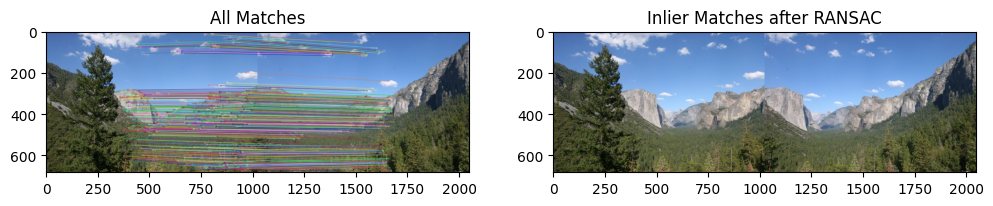

In [22]:
matches = matching_feature_second(descriptors1, descriptors2)
img_matches, img_inliers = visualize_matches(image1, image2, keypoints1, keypoints2, matches, inliers)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("All Matches")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_inliers, cv2.COLOR_BGR2RGB))
plt.title("Inlier Matches after RANSAC")

# Image stitching

In [23]:
def stitch_img(left, right, H):
    print("Stitching images with linear blending...")

    left = left.astype('float')
    right = right.astype('float')
    height_l, width_l, _ = left.shape
    height_r, width_r, _ = right.shape

    # Compute corners of both images
    corners_left = np.array([[0, 0, 1],
                              [width_l, 0, 1],
                              [width_l, height_l, 1],
                              [0, height_l, 1]])
    corners_right = np.array([[0, 0, 1],
                               [width_r, 0, 1],
                               [width_r, height_r, 1],
                               [0, height_r, 1]])
    
    # Transform corners of the left image using H
    corners_transformed_left = (H @ corners_left.T).T
    corners_transformed_left /= corners_transformed_left[:, 2:3]  # Normalize by the third coordinate (homogeneous division)

    # Combine corners to find the canvas bounds
    all_corners = np.vstack((corners_transformed_left[:, :2], corners_right[:, :2]))
    x_min, y_min = np.floor(all_corners.min(axis=0)).astype(int)
    x_max, y_max = np.ceil(all_corners.max(axis=0)).astype(int)

    # Calculate translation to shift all coordinates to positive
    translation_mat = np.array([[1, 0, -x_min],
                                 [0, 1, -y_min],
                                 [0, 0, 1]], dtype=np.float32)

    # Canvas size
    height_new = y_max - y_min
    width_new = x_max - x_min
    size = (width_new, height_new)

    # Warp images into the new canvas
    warped_left = cv2.warpPerspective(src=left, M=translation_mat @ H, dsize=size)
    warped_right = cv2.warpPerspective(src=right, M=translation_mat, dsize=size)

    # Blending
    # Create a mask for blending
    mask_left = (warped_left > 0).astype('float')  # Mask where the left image is present
    mask_right = (warped_right > 0).astype('float')  # Mask where the right image is present
    overlap_mask = mask_left * mask_right  # Find overlap

    # Avoid division by zero in the overlap region
    blended = warped_left * (1 - overlap_mask) + warped_right * (1 - overlap_mask) + \
              (warped_left + warped_right) * overlap_mask / 2

    # Convert to uint8
    result = np.clip(blended, 0, 255).astype('uint8')
    return result


In [24]:
#Testing Using SIFT
image1 = cv2.imread('data3/1.JPG')
keypoints1,descriptors1 = SIFT(image1)
image2 = cv2.imread('data3/2.JPG')
keypoints2,descriptors2 = SIFT(image2)
matching = matching_feature(descriptors1,descriptors2)
inliers, H = ransac(matching, keypoints1, keypoints2, 0.5, 2000)


Number of matches: 938
inliers/matches: 521/938


Stitching images with linear blending...


True

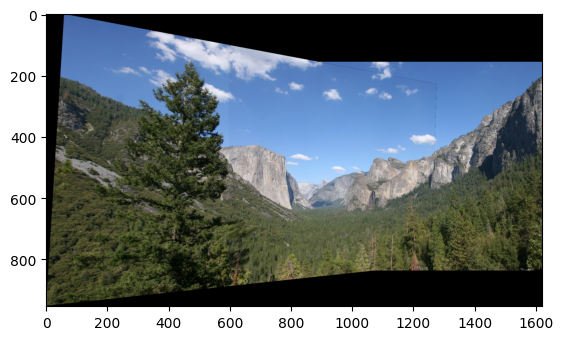

In [25]:
image = stitch_img(image1, image2, H)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.imwrite('output/data3.jpg', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Multiple Image

In [26]:
def helper(image1, image2):
    keypoints1,descriptors1 = SIFT(image1)
    keypoints2,descriptors2 = SIFT(image2)
    matching = matching_feature(descriptors1,descriptors2)
    inliers, H = ransac(matching, keypoints1, keypoints2, 0.5, 2000)
    return stitch_img(image1, image2, H)

In [27]:
def recurse(image_list, nums):
    if nums == 2:
        result = helper(image_list[nums-2],image_list[nums-1])
        return result
    else :
        result = helper(image_list[nums-2],image_list[nums-1])
        image_list[nums-2] = result
        return recurse(image_list,nums-1)

In [35]:
#main 
image_lists = load_images('data1')
image_lists.reverse()
mosaic_image = recurse(image_lists,len(image_lists))
plt.imshow(cv2.cvtColor(mosaic_image, cv2.COLOR_BGR2RGB))

Number of matches: 4496
inliers/matches: 1556/4496
Stitching images with linear blending...
Number of matches: 5564
inliers/matches: 1786/5564
Stitching images with linear blending...
Number of matches: 14237


KeyboardInterrupt: 

In [1]:
import os
import cv2
import math
import numpy as np
      


#load image 
def load_images(dataset):
    data1=['data1/1.JPG','data1/2.JPG','data1/3.JPG','data1/4.JPG','data1/5.JPG','data1/6.JPG']
    data2 =['data2/IMG_0488.JPG','data2/IMG_0489.JPG','data2/IMG_0490.JPG','data2/IMG_0491.JPG']
    data3 =['data3/1.JPG','data3/2.JPG','data3/3.JPG']
    data4 = ['data4/1.JPG','data4/2.JPG','data4/3.JPG','data4/4.JPG']
    if dataset =='data1':
        image_paths = data1
    elif dataset == 'data2':
        image_paths = data2
    elif dataset == 'data3':
        image_paths = data3
    else:
        image_paths = data4
    return [cv2.imread(path) for path in image_paths]
    
def FindMatches(BaseImage, SecImage):
    # Using SIFT to find the keypoints and decriptors in the images
    Sift = cv2.SIFT_create()
    BaseImage_kp, BaseImage_des = Sift.detectAndCompute(cv2.cvtColor(BaseImage, cv2.COLOR_BGR2GRAY), None)
    SecImage_kp, SecImage_des = Sift.detectAndCompute(cv2.cvtColor(SecImage, cv2.COLOR_BGR2GRAY), None)

    # Using Brute Force matcher to find matches.
    BF_Matcher = cv2.BFMatcher()
    InitialMatches = BF_Matcher.knnMatch(BaseImage_des, SecImage_des, k=2)

    # Applytng ratio test and filtering out the good matches.
    GoodMatches = []
    for m, n in InitialMatches:
        if m.distance < 0.75 * n.distance:
            GoodMatches.append([m])

    return GoodMatches, BaseImage_kp, SecImage_kp



def FindHomography(Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code.
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    # Storing coordinates of points corresponding to the matches found in both the images
    BaseImage_pts = []
    SecImage_pts = []
    for Match in Matches:
        BaseImage_pts.append(BaseImage_kp[Match[0].queryIdx].pt)
        SecImage_pts.append(SecImage_kp[Match[0].trainIdx].pt)

    # Changing the datatype to "float32" for finding homography
    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)

    # Finding the homography matrix(transformation matrix).
    (HomographyMatrix, Status) = cv2.findHomography(SecImage_pts, BaseImage_pts, cv2.RANSAC, 4.0)

    return HomographyMatrix, Status

    
def GetNewFrameSizeAndMatrix(HomographyMatrix, Sec_ImageShape, Base_ImageShape):
    # Reading the size of the image
    (Height, Width) = Sec_ImageShape
    
    # Taking the matrix of initial coordinates of the corners of the secondary image
    # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
    # Where (xt, yt) is the coordinate of the i th corner of the image. 
    InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                              [0, 0, Height - 1, Height - 1],
                              [1, 1, 1, 1]])
    
    # Finding the final coordinates of the corners of the image after transformation.
    # NOTE: Here, the coordinates of the corners of the frame may go out of the 
    # frame(negative values). We will correct this afterwards by updating the 
    # homography matrix accordingly.
    FinalMatrix = np.dot(HomographyMatrix, InitialMatrix)

    [x, y, c] = FinalMatrix
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the stitched image frame and the "Correction" factor
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    New_Width = max_x
    New_Height = max_y
    Correction = [0, 0]
    if min_x < 0:
        New_Width -= min_x
        Correction[0] = abs(min_x)
    if min_y < 0:
        New_Height -= min_y
        Correction[1] = abs(min_y)
    
    # Again correcting New_Width and New_Height
    # Helpful when secondary image is overlaped on the left hand side of the Base image.
    if New_Width < Base_ImageShape[1] + Correction[0]:
        New_Width = Base_ImageShape[1] + Correction[0]
    if New_Height < Base_ImageShape[0] + Correction[1]:
        New_Height = Base_ImageShape[0] + Correction[1]

    # Finding the coordinates of the corners of the image if they all were within the frame.
    x = np.add(x, Correction[0])
    y = np.add(y, Correction[1])
    OldInitialPoints = np.float32([[0, 0],
                                   [Width - 1, 0],
                                   [Width - 1, Height - 1],
                                   [0, Height - 1]])
    NewFinalPonts = np.float32(np.array([x, y]).transpose())

    # Updating the homography matrix. Done so that now the secondary image completely 
    # lies inside the frame
    HomographyMatrix = cv2.getPerspectiveTransform(OldInitialPoints, NewFinalPonts)
    
    return [New_Height, New_Width], Correction, HomographyMatrix



def StitchImages(BaseImage, SecImage):
    # Applying Cylindrical projection on SecImage
    SecImage_Cyl, mask_x, mask_y = ProjectOntoCylinder(SecImage)

    # Getting SecImage Mask
    SecImage_Mask = np.zeros(SecImage_Cyl.shape, dtype=np.uint8)
    SecImage_Mask[mask_y, mask_x, :] = 255

    # Finding matches between the 2 images and their keypoints
    Matches, BaseImage_kp, SecImage_kp = FindMatches(BaseImage, SecImage_Cyl)
    
    # Finding homography matrix.
    HomographyMatrix, Status = FindHomography(Matches, BaseImage_kp, SecImage_kp)
    
    # Finding size of new frame of stitched images and updating the homography matrix 
    NewFrameSize, Correction, HomographyMatrix = GetNewFrameSizeAndMatrix(HomographyMatrix, SecImage_Cyl.shape[:2], BaseImage.shape[:2])

    # Finally placing the images upon one another.
    SecImage_Transformed = cv2.warpPerspective(SecImage_Cyl, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    SecImage_Transformed_Mask = cv2.warpPerspective(SecImage_Mask, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    BaseImage_Transformed = np.zeros((NewFrameSize[0], NewFrameSize[1], 3), dtype=np.uint8)
    BaseImage_Transformed[Correction[1]:Correction[1]+BaseImage.shape[0], Correction[0]:Correction[0]+BaseImage.shape[1]] = BaseImage

    StitchedImage = cv2.bitwise_or(SecImage_Transformed, cv2.bitwise_and(BaseImage_Transformed, cv2.bitwise_not(SecImage_Transformed_Mask)))

    return StitchedImage


def Convert_xy(x, y):
    global center, f

    xt = ( f * np.tan( (x - center[0]) / f ) ) + center[0]
    yt = ( (y - center[1]) / np.cos( (x - center[0]) / f ) ) + center[1]
    
    return xt, yt


def ProjectOntoCylinder(InitialImage):
    global w, h, center, f
    h, w = InitialImage.shape[:2]
    center = [w // 2, h // 2]
    f = 1100       # 1100 field; 1000 Sun; 1500 Rainier; 1050 Helens
    
    # Creating a blank transformed image
    TransformedImage = np.zeros(InitialImage.shape, dtype=np.uint8)
    
    # Storing all coordinates of the transformed image in 2 arrays (x and y coordinates)
    AllCoordinates_of_ti =  np.array([np.array([i, j]) for i in range(w) for j in range(h)])
    ti_x = AllCoordinates_of_ti[:, 0]
    ti_y = AllCoordinates_of_ti[:, 1]
    
    # Finding corresponding coordinates of the transformed image in the initial image
    ii_x, ii_y = Convert_xy(ti_x, ti_y)

    # Rounding off the coordinate values to get exact pixel values (top-left corner)
    ii_tl_x = ii_x.astype(int)
    ii_tl_y = ii_y.astype(int)

    # Finding transformed image points whose corresponding 
    # initial image points lies inside the initial image
    GoodIndices = (ii_tl_x >= 0) * (ii_tl_x <= (w-2)) * \
                  (ii_tl_y >= 0) * (ii_tl_y <= (h-2))

    # Removing all the outside points from everywhere
    ti_x = ti_x[GoodIndices]
    ti_y = ti_y[GoodIndices]
    
    ii_x = ii_x[GoodIndices]
    ii_y = ii_y[GoodIndices]

    ii_tl_x = ii_tl_x[GoodIndices]
    ii_tl_y = ii_tl_y[GoodIndices]

    # Bilinear interpolation
    dx = ii_x - ii_tl_x
    dy = ii_y - ii_tl_y

    weight_tl = (1.0 - dx) * (1.0 - dy)
    weight_tr = (dx)       * (1.0 - dy)
    weight_bl = (1.0 - dx) * (dy)
    weight_br = (dx)       * (dy)
    
    TransformedImage[ti_y, ti_x, :] = ( weight_tl[:, None] * InitialImage[ii_tl_y,     ii_tl_x,     :] ) + \
                                      ( weight_tr[:, None] * InitialImage[ii_tl_y,     ii_tl_x + 1, :] ) + \
                                      ( weight_bl[:, None] * InitialImage[ii_tl_y + 1, ii_tl_x,     :] ) + \
                                      ( weight_br[:, None] * InitialImage[ii_tl_y + 1, ii_tl_x + 1, :] )


    # Getting x coorinate to remove black region from right and left in the transformed image
    min_x = min(ti_x)

    # Cropping out the black region from both sides (using symmetricity)
    TransformedImage = TransformedImage[:, min_x : -min_x, :]

    return TransformedImage, ti_x-min_x, ti_y


if __name__ == "__main__":
    # Reading images.
    Images = load_images("data4")
    BaseImage, _, _ = ProjectOntoCylinder(Images[1])
    for i in range(0, len(Images)):
        if i != 2:
            StitchedImage = StitchImages(BaseImage, Images[i])

        BaseImage = StitchedImage.copy()    

    cv2.imwrite("Stitched_Panorama.png", BaseImage)